In [1]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc4
import xarray as xr
import datetime
from dateutil.relativedelta import relativedelta

from src.utils import modif_plot

# Extract Landy SIT

In [2]:
#odir = '/nird/projects/nird/NS2993K/Leo/SIT_observations/Landy_2022/'
odir = '/scratch/project_465000269/edelleo1/Leo/SIT_observations/Landy_2022/'
ofile = f'ubristol_cryosat2_seaicethickness_nh_80km_v1p7.nc'

In [3]:
nc = xr.open_mfdataset(f'{odir}{ofile}', decode_times=False) # , combine='nested', concat_dim='time')

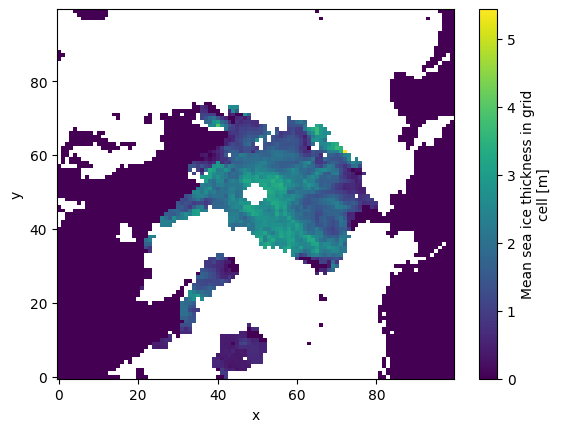

In [4]:
nc['Sea_Ice_Thickness'].isel(t=160).plot()

## get datetime right

In [5]:
d1 = datetime.datetime(1,1,1)

In [6]:
units1 = f'days since 0001-01-01'  # + 1 year than the dataset

In [7]:
ndays = nc['Time'].to_numpy()

In [8]:
# we substract the additional year
all_days = np.array([d1 + datetime.timedelta(days=x) - relativedelta(years=1) for x in ndays])

In [9]:
da = xr.DataArray(
    data=all_days,
    dims=["t"],
    attrs=dict(
        standard_name='time',
        description="Datetime"
    ),
)

In [10]:
nc = nc.assign_coords(t=da)

---

## Extract variables

In [11]:
glat = nc['Latitude']
glon = nc['Longitude']
sit_l = nc['Sea_Ice_Thickness']
situ = nc['Sea_Ice_Thickness_Uncertainty']
cc = nc['Sea_Ice_Concentration']

# Project on TOPAZ grid

In [16]:
import pyproj
from src.modules.grid.grid import Grid
from src.modules.topaz.v4.confmap import ConformalMapping

In [17]:
# load information for TOPAZ grid
cm = ConformalMapping.init_from_file('/users/edelleo1/tardis/tardis-ml/src/modules/grid.info')

In [18]:
# from src.modules.topaz.__init__()
# part of function >>read_grid()<<

nx = cm._ires
ny = cm._jres

ii, jj = np.meshgrid(np.arange(nx), np.arange(ny))
lat, lon = cm.gind2ll(ii+1., jj+1.)

# ##find grid resolution
geod = pyproj.Geod(ellps='sphere')
_,_,dist_x = geod.inv(lon[:,1:], lat[:,1:], lon[:,:-1], lat[:,:-1])
_,_,dist_y = geod.inv(lon[1:,:], lat[1:,:], lon[:-1,:], lat[:-1,:])
dx = np.median(dist_x)
dy = np.median(dist_y)

##the coordinates in topaz model native grid
x = ii*dx
y = jj*dy

##proj function that mimic what pyproj.Proj object does to convert x,y to lon,lat
def proj(x, y, inverse=False):
    if not inverse:
        i, j = cm.ll2gind(y, x)
        xo = (i-1)*dx
        yo = (j-1)*dy
    else:
        i = np.atleast_1d(x/dx + 1)
        j = np.atleast_1d(y/dy + 1)
        yo, xo = cm.gind2ll(i, j)
    if xo.size == 1:
        return xo.item(), yo.item()
    return xo, yo

# TOPAZ grid

#### Jiping used ANOTHER GRID for my version of TOPAZ

In [19]:
# my TOPAZ:

In [20]:
mtp_proj = pyproj.Proj('+proj=stere +lon_0=-45 +lat_0=90 +k=1 +R=6378273 +no_defs')

In [21]:
# get x, y

In [22]:
ifile = '/scratch/project_465000269/edelleo1/Leo/Jiping_2023/TP4b/20221231_dm-12km-NERSC-MODEL-TOPAZ4B-ARC-RAN.fv2.0.nc'

In [23]:
nc_tp = nc4.Dataset(f'{ifile}', mode='r')
sit = xr.open_dataset(xr.backends.NetCDF4DataStore(nc_tp))['sithick']

In [24]:
xt, yt = np.meshgrid(sit.x.to_numpy(), sit.y.to_numpy())

In [25]:
t_grid = Grid(mtp_proj, xt*100000, yt*100000)

# LANDY grid

from ncdump -h ubristol...nc

		:Grid = "polar stereographic, wgs84, Latitude_of_origin=70, central_meridian=0" ;
		:Spatial_Resolution_km = "80" ;
		:geospatial_lon_min = "-179.4" ;
		:geospatial_lon_max = "179.4" ;
		:geospatial_lat_min = "41.3" ;
		:geospatial_lat_max = "89.5" ;
		:geospatial_bounds_crs = "EPSG:4326" ;

There is still an offset with the TOPAZ grid... Wrong definition ?

In [26]:
in_proj = pyproj.Proj('+proj=stere +lon_0=0 +lat_0=90 +lat_ts=70 +EPSG:4326 +datum=WGS84 +units=m +no_defs +k=1 +x_0=0 +y_0=0')

# Convert LANDY with grid (Yue's module)

Something is wrong with the X/Y used: they are not projected, just indexes

In [27]:
# create gridx, gridy (Landy) - in meters already
# in_proj(glon[0][0], glat[0][0])
xp, yp = in_proj(glon, glat)

In [28]:
data_in = sit_l[15].to_numpy().T

In [29]:
# d_grid = Grid(in_proj, x.T, y.T)

In [32]:
d_grid = Grid.regular_grid(in_proj, -3960000, 3960000+1, -3960000, 3960000+1, 80000)

In [33]:
# define destination grid
d_grid.dst_grid = t_grid

In [34]:
# convert data
data_out = d_grid.convert(data_in, method='linear')

## Plot input/output

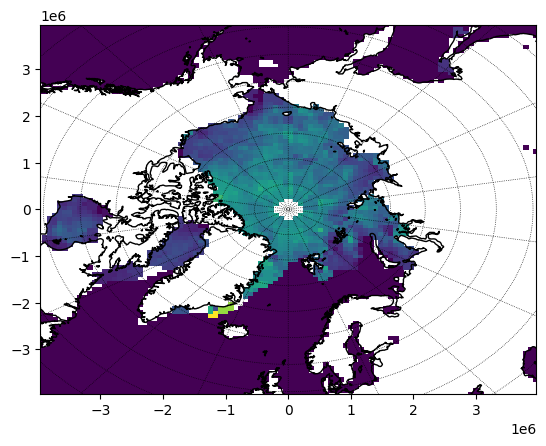

In [35]:
fig, ax = plt.subplots(1,1)
d_grid.plot_land(ax)
d_grid.plot_field(ax, data_in)

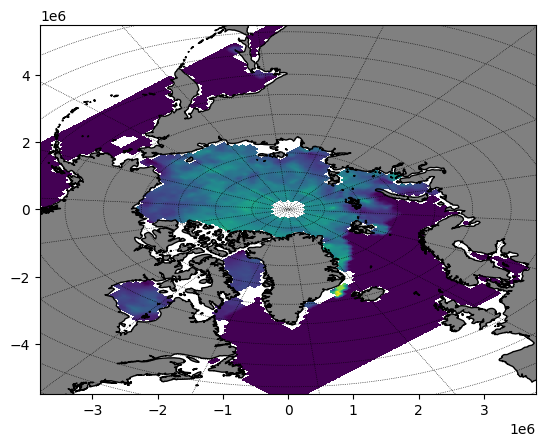

In [94]:
fig, ax = plt.subplots(1,1)
t_grid.plot_land(ax, color='grey')
t_grid.plot_field(ax, data_out)

In [37]:
# select the domain on TOPAZ we want
# data_out2 = data_out[150:629, 100:550]

# Sea Ice Volume

In [38]:
area = (d_grid.dx / d_grid.mfx) * (d_grid.dy / d_grid.mfx)

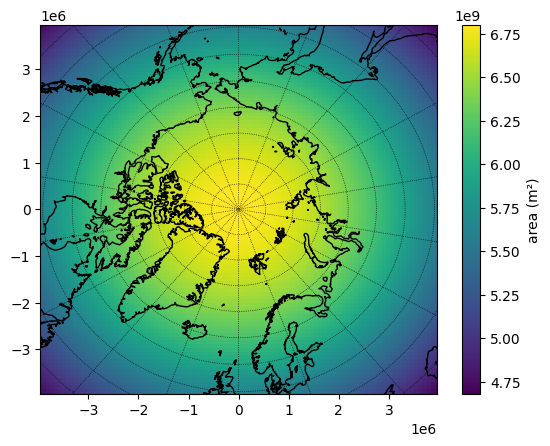

In [39]:
fig, ax = plt.subplots(1,1)
d_grid.plot_land(ax)
cm = d_grid.plot_field(ax, area)
fig.colorbar(cm, label='area (m²)')

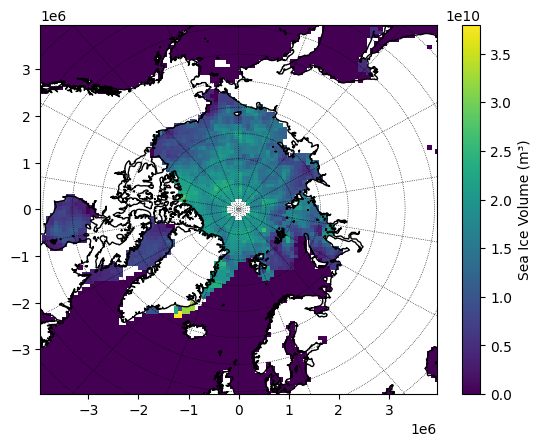

In [40]:
fig, ax = plt.subplots(1,1)
d_grid.plot_land(ax)
cm = d_grid.plot_field(ax, area*data_in)
fig.colorbar(cm, label='Sea Ice Volume (m³)')

In [41]:
sit_c15 = (sit_l.where((.15<cc))).where(np.isfinite(sit_l))  # average sit with sic > 0.15

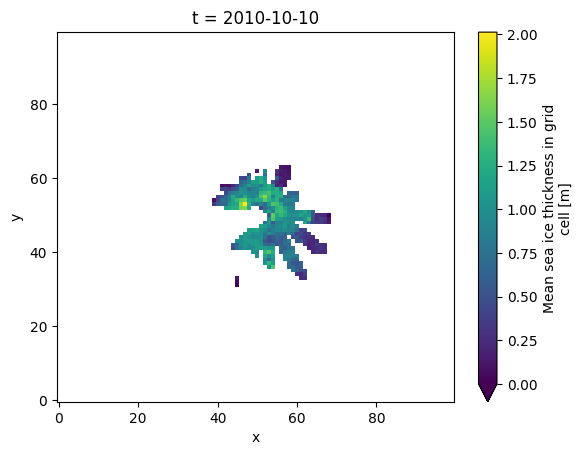

In [42]:
sit_c15.isel(t=0).plot(vmin=0)

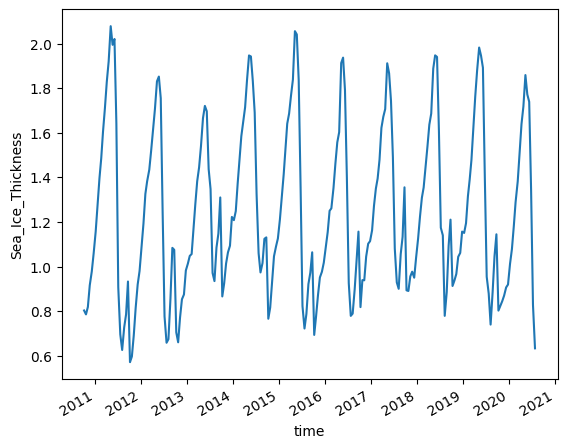

In [43]:
sit_c15.mean(('x','y')).plot()

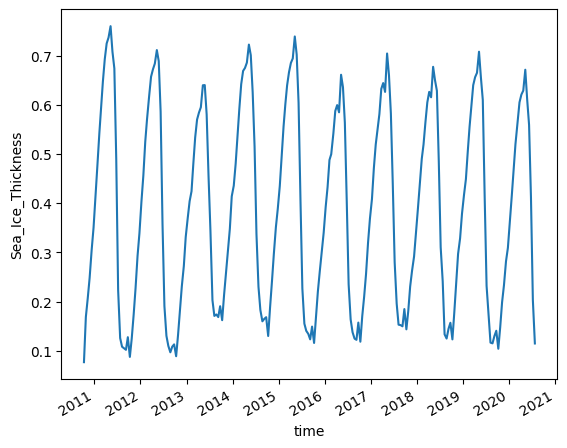

In [44]:
sit_l.mean(('x','y')).plot()

In [45]:
siv = sit_l * area * cc

In [46]:
siv.name = 'Sea_Ice_Volume'
siv = siv.assign_attrs(units = 'm³',
                description = 'Sea Ice Thickness * Area * Concentration',
                dataset = 'Landy 2022',
                projection = '+proj=stere +lon_0=0 +lat_0=90 +lat_ts=70 +EPSG:4326 +datum=WGS84 +units=m +no_defs +k=1 +x_0=0 +y_0=0')

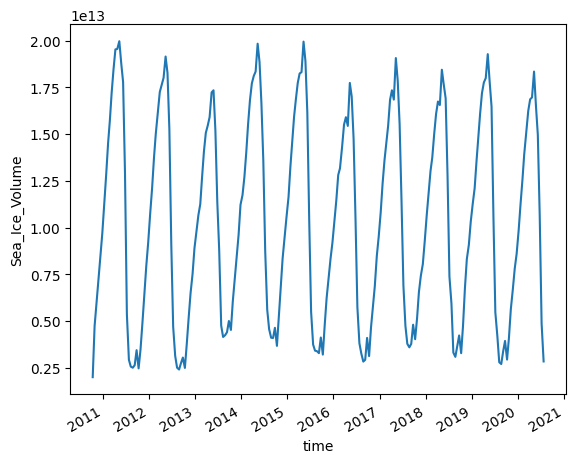

In [47]:
siv.sum(('x','y')).plot()

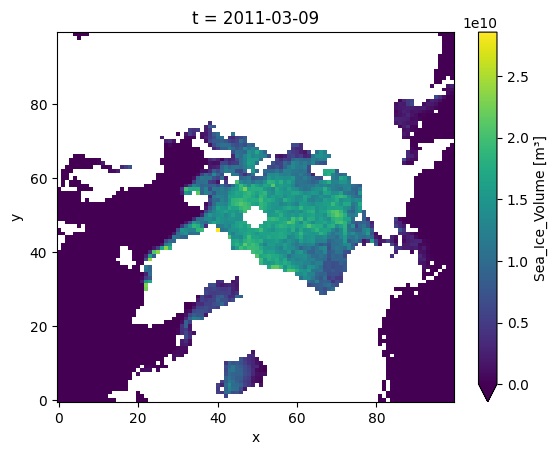

In [95]:
siv.isel(t=10).plot(vmin=0)

--------------------------

# Convert each day 

In [49]:
def convert_alldays(grid, data_in, jlim=(100, 550), ilim=(150, 629)):
    '''
    Convert from Landy grid to TOPAZ grid (4b 2023 netcdf files, produced by Jiping)
    
    grid   : src.modules.grid.grid.grid.Grid
    new limits: [150:629, 100:550]
    '''
    
    
    
    nj = jlim[1] - jlim[0]  # number of j
    ni = ilim[1] - ilim[0] #  number of i
    nday = data_in.shape[0] # number of days
    data_out = np.zeros((nday, ni, nj))    
    
    for day in range(nday):
        data_out[day] = grid.convert(data_in[day])[ilim[0]:ilim[1], jlim[0]:jlim[1]]
        
    return data_out
    

In [50]:
sit_l_out = convert_alldays(d_grid, sit_l.to_numpy())

In [51]:
sit_lunc_out = convert_alldays(d_grid, situ.to_numpy())

In [52]:
sic_l_out = convert_alldays(d_grid, cc.to_numpy())

## Convert to xarray

In [103]:
yt.shape

(880,)

In [104]:
sit_l_out.shape

(236, 479, 450)

In [53]:
xt = x[0,:]
yt = y[:,0]

In [107]:
xtc = xt[100:550]
ytc = yt[150:629]

In [109]:
xtc = xt[150:629]
ytc = yt[100:550]

In [110]:
da_sit = xr.DataArray(
    data=sit_l_out[:, ::-1, ::-1].data,
    dims=["time", "y", "x"],
    coords=dict(
        x=(["x"], ytc),
        y=(["y"], xtc[::-1]),
        time=(["time"], nc.t.data)
    ),
    attrs=dict(
        name="Sea ice thickness",
        description="Landy product projected on TOPAZ4b grid",
        units="m",
    ),
)

da_sit.name = 'Sea_Ice_Thickness'

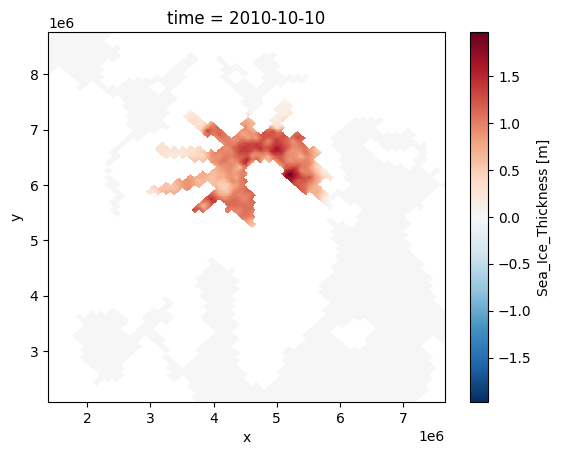

In [111]:
da_sit.isel(time=0).plot()

In [76]:
da_situ = xr.DataArray(
    data=sit_lunc_out[:, ::-1, ::-1].data,
    dims=["time", "y", "x"],
    coords=dict(
        x=(["x"], xtc),
        y=(["y"], ytc[::-1]),
        time=(["time"], nc.t.data)
    ),
    attrs=dict(
        name="Sea ice thickness uncertainty",
        description="Landy product projected on TOPAZ4b grid",
        units="m",
    ),
)

da_situ.name = 'Sea_Ice_Thickness_Uncertainty'

In [77]:
da_sic = xr.DataArray(
    data=sic_l_out[:, ::-1, ::-1].data,
    dims=["time", "y", "x"],
    coords=dict(
        x=(["x"], xtc),
        y=(["y"], ytc[::-1]),
        time=(["time"], nc.t.data)
    ),
    attrs=dict(
        name="Sea ice concentration",
        description="Landy product projected on TOPAZ4b grid",
        units="%",
    ),
)

da_sic.name = 'Sea_Ice_Concentration'

In [49]:
# need to cap sea ice thickness to 0 (negative SIT due to projection)

In [84]:
da_sit = (da_sit.where((0<da_sit), 0)).where(np.isfinite(da_sit))

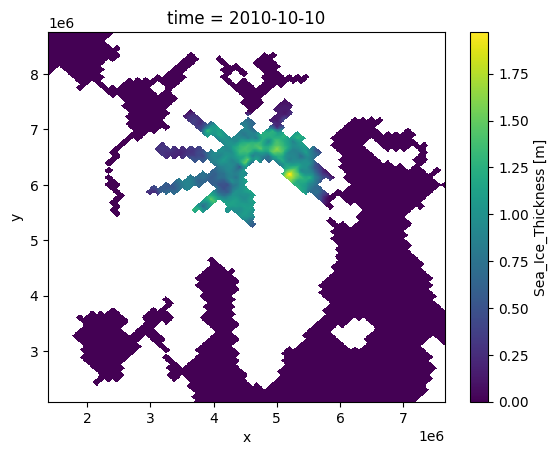

In [85]:
da_sit.isel(time=0).plot()

# Xarray Dataset

In [86]:
ds = xr.merge((da_sit, da_situ, da_sic))

In [87]:
ds.attrs['name'] = 'Landy22'

## Save .nc

In [92]:
odir = '/scratch/project_465000269/edelleo1/Leo/SIT_observations/Landy_2022/'
ofile = f'ubristol_cryosat2_seaicethickness_nh_80km_v1p7_reproj_TOPAZ4b_TARDIS_new.nc'

In [93]:
ds.to_netcdf(f'{odir}{ofile}')
print(f'Saved as: {odir}{ofile}')

Saved as: /scratch/project_465000269/edelleo1/Leo/SIT_observations/Landy_2022/ubristol_cryosat2_seaicethickness_nh_80km_v1p7_reproj_TOPAZ4b_TARDIS_new.nc


# --------------------------- END ---------------------------------------------

## Plot

----

### Create datasets with SIT and SIT uncertainty average

In [21]:
sitm_c15.data

dask.array<mean_agg-aggregate, shape=(236,), dtype=float64, chunksize=(236,), chunktype=numpy.ndarray>

In [24]:
nc['Sea_Ice_Concentration'][:].data

dask.array<open_dataset-09992e959c214c81a962c96ffeba71faSea_Ice_Concentration, shape=(236, 100, 100), dtype=float64, chunksize=(236, 100, 100), chunktype=numpy.ndarray>

In [35]:
data_vars = {'Sea_Ice_Thickness':(['t'], sitm_c15.data, 
                                 {'units':'m',
                                 'description':'only for sea ice concentration > 15%'}),
           'Sea_Ice_Thickness_Uncertainty': (['t'], situm_c15.data, 
                                 {'units':'m',
                                 'description':'only for sea ice concentration > 15%'}),
             'Sea_Ice_Volume':(['t'], vol_15.data,
                                 {'units':'m3',
                                 'description':'sea ice thickness (sic>15%) x sea ice concentration'})
            }

coords = {'t': (['t'], da.data)}


In [36]:
ds15 = xr.Dataset(data_vars=data_vars, coords=coords, attrs={})

In [80]:
data_vars = {'Sea_Ice_Thickness':(['t'], sitm_c0.data, 
                                 {'units':'m',
                                 'description':'only for sea ice concentration > 0%'}),
           'Sea_Ice_Thickness_Uncertainty': (['t'], situm_c0.data, 
                                 {'units':'m',
                                 'description':'only for sea ice concentration > 0%'})}

coords = {'t': (['t'], da.data)}


In [81]:
ds0 = xr.Dataset(data_vars=data_vars, coords=coords, attrs={})

In [40]:
ds15

<xarray.Dataset>
Dimensions:                        (t: 236)
Coordinates:
  * t                              (t) datetime64[ns] 2010-10-10 ... 2020-07-25
Data variables:
    Sea_Ice_Thickness              (t) float64 dask.array<chunksize=(236,), meta=np.ndarray>
    Sea_Ice_Thickness_Uncertainty  (t) float64 dask.array<chunksize=(236,), meta=np.ndarray>
    Sea_Ice_Volume                 (t) float64 dask.array<chunksize=(236,), meta=np.ndarray>

----

## Save .nc

In [37]:
start_date = all_days[0].strftime('%Y%m%d')
end_date = all_days[-1].strftime('%Y%m%d')
str_date = f'{start_date}_{end_date}'

In [43]:
odir = '/scratch/project_465000269/edelleo1/Leo/SIT_observations/Landy_2022/results/'
#ofile = f'Landy22_SIT_mean_SIC0_{str_date}.nc'
#ds0.to_netcdf(f'{odir}{ofile}')

ofile = f'Landy22_SIT_mean_SIC15_{str_date}.nc'
ds15.to_netcdf(f'{odir}{ofile}')